In [1]:
import os
import gc
import pandas as pd
from tqdm.notebook import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
path_news = './stock/vn/business_news/'
list_file_news = [os.path.join(path_news, filename) for filename in os.listdir(path_news) if os.path.isfile(os.path.join(path_news, filename))]

In [3]:
import requests
import urllib

def translate(text):
    f = {'key' : 'trnsl.1.1.20210911T110121Z.b17804374c5bae96.39b65931bf5bb5b7faa7bf11f1f811eba5bd9a1b', 
         'text' : text,
         'lang' : 'vi-en',
         'format' : 'plain'
        }

    url = 'https://translate.yandex.net/api/v1.5/tr.json/translate?' + urllib.parse.urlencode(f)
    
    count_retry = 5
    while(count_retry >= 0):
        try:
            response = requests.get(url)
            return response.json()['text'][0]
        except:
            print(f'failed. Remaining retry {count_retry}...')
            count_retry -= 1
        
    return np.NaN

In [4]:
translate("Việt Nam đất nước tôi")

'Vietnam, my country'

In [4]:
def translate_df(df, symbol):
    print(df.shape)
    total_row = len(df)
    row_completed = 0
    df['article_concat_en'] = ''
    for index, row in df.iterrows():
        df.loc[df.index == index, 'article_concat_en'] = translate(row['article_concat'])
        row_completed += 1
        print(f'{symbol} - {index} done, {row_completed}/{total_row} completed')
        
    return df

In [5]:
list_vn30 = pd.read_csv('list_vn_hsx30.csv')['symbol'].unique()

In [6]:
list_vn30

array(['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG',
       'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW',
       'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

In [7]:
filter_start_time = '2009-06-01'

for file in tqdm(list_file_news):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
    
    if file_name not in list_vn30:
        continue
    
    if not (file_name == 'SAB'):
        continue
    
    file_translated = f'./stock/vn/business_news_en/{basename}'
    if os.path.isfile(file_translated):
        continue
    
    print(f'start processing file {basename}')
    
    df_news = pd.read_csv(file)[['time', 'title_name', 'para']]
    
    df_news.loc[df_news['time'].str.contains('trước'), 'time'] = 'Aug 06, 2021'
    
    df_news['para'] = df_news['para'].str.replace('Investing.com', ' ', regex=False)
    df_news['para'] = df_news['para'].str.replace('Vietstock', ' ', regex=False)
    
    df_news['Date'] = pd.to_datetime(df_news['time'])
    df_news = df_news[df_news['Date'] >= filter_start_time]
    df_news.drop_duplicates(subset=['title_name'], keep='first', inplace=True)
    df_news.drop('time', axis=1, inplace=True)
    df_news['symbol'] = file_name
    df_news.rename(columns={'title_name' : 'article_title'}, inplace=True)
    df_news.rename(columns={'para' : 'article_abstract'}, inplace=True)
    df_news = df_news[['symbol', 'Date', 'article_title', 'article_abstract']]
    
    df_news[['article_title', 'article_abstract']] = df_news[['article_title', 'article_abstract']].fillna('')
    df_news['article_concat'] = df_news['article_title'] + ' ' + df_news['article_abstract']
    df_news['article_concat'] = df_news['article_concat'].str.strip()
    
    df_news = translate_df(df_news, symbol=file_name)
    
    df_news.to_csv(file_translated, index=False)

  0%|          | 0/192 [00:00<?, ?it/s]

start processing file SAB.csv
(766, 5)
SAB - 0 done, 1/766 completed
SAB - 1 done, 2/766 completed
SAB - 2 done, 3/766 completed
SAB - 3 done, 4/766 completed
SAB - 4 done, 5/766 completed
SAB - 5 done, 6/766 completed
SAB - 6 done, 7/766 completed
SAB - 7 done, 8/766 completed
SAB - 8 done, 9/766 completed
SAB - 9 done, 10/766 completed
SAB - 20 done, 11/766 completed
SAB - 21 done, 12/766 completed
SAB - 22 done, 13/766 completed
SAB - 23 done, 14/766 completed
SAB - 24 done, 15/766 completed
SAB - 25 done, 16/766 completed
SAB - 26 done, 17/766 completed
SAB - 27 done, 18/766 completed
SAB - 28 done, 19/766 completed
SAB - 29 done, 20/766 completed
SAB - 50 done, 21/766 completed
SAB - 51 done, 22/766 completed
SAB - 52 done, 23/766 completed
SAB - 53 done, 24/766 completed
SAB - 54 done, 25/766 completed
SAB - 55 done, 26/766 completed
SAB - 56 done, 27/766 completed
SAB - 57 done, 28/766 completed
SAB - 58 done, 29/766 completed
SAB - 59 done, 30/766 completed
SAB - 90 done, 31/76

SAB - 3242 done, 243/766 completed
SAB - 3243 done, 244/766 completed
SAB - 3244 done, 245/766 completed
SAB - 3245 done, 246/766 completed
SAB - 3246 done, 247/766 completed
SAB - 3247 done, 248/766 completed
SAB - 3248 done, 249/766 completed
SAB - 3249 done, 250/766 completed
SAB - 3500 done, 251/766 completed
SAB - 3501 done, 252/766 completed
SAB - 3502 done, 253/766 completed
SAB - 3503 done, 254/766 completed
SAB - 3504 done, 255/766 completed
SAB - 3505 done, 256/766 completed
SAB - 3506 done, 257/766 completed
SAB - 3507 done, 258/766 completed
SAB - 3508 done, 259/766 completed
SAB - 3768 done, 260/766 completed
SAB - 3769 done, 261/766 completed
SAB - 3770 done, 262/766 completed
SAB - 3771 done, 263/766 completed
SAB - 3772 done, 264/766 completed
SAB - 3773 done, 265/766 completed
SAB - 3774 done, 266/766 completed
SAB - 3775 done, 267/766 completed
SAB - 3776 done, 268/766 completed
SAB - 3777 done, 269/766 completed
SAB - 4048 done, 270/766 completed
SAB - 4049 done, 271

SAB - 11722 done, 476/766 completed
SAB - 11723 done, 477/766 completed
SAB - 12202 done, 478/766 completed
SAB - 12203 done, 479/766 completed
SAB - 12204 done, 480/766 completed
SAB - 12205 done, 481/766 completed
SAB - 12206 done, 482/766 completed
SAB - 12207 done, 483/766 completed
SAB - 12208 done, 484/766 completed
SAB - 12209 done, 485/766 completed
SAB - 12210 done, 486/766 completed
SAB - 12211 done, 487/766 completed
SAB - 12700 done, 488/766 completed
SAB - 12701 done, 489/766 completed
SAB - 12702 done, 490/766 completed
SAB - 12703 done, 491/766 completed
SAB - 12704 done, 492/766 completed
SAB - 12705 done, 493/766 completed
SAB - 12706 done, 494/766 completed
SAB - 12707 done, 495/766 completed
SAB - 12708 done, 496/766 completed
SAB - 12709 done, 497/766 completed
SAB - 13208 done, 498/766 completed
SAB - 13209 done, 499/766 completed
SAB - 13210 done, 500/766 completed
SAB - 13211 done, 501/766 completed
SAB - 13212 done, 502/766 completed
SAB - 13213 done, 503/766 co

SAB - 25474 done, 704/766 completed
SAB - 25475 done, 705/766 completed
SAB - 25476 done, 706/766 completed
SAB - 25477 done, 707/766 completed
SAB - 26186 done, 708/766 completed
SAB - 26187 done, 709/766 completed
SAB - 26188 done, 710/766 completed
SAB - 26189 done, 711/766 completed
SAB - 26190 done, 712/766 completed
SAB - 26191 done, 713/766 completed
SAB - 26192 done, 714/766 completed
SAB - 26193 done, 715/766 completed
SAB - 26194 done, 716/766 completed
SAB - 26195 done, 717/766 completed
SAB - 26914 done, 718/766 completed
SAB - 26915 done, 719/766 completed
SAB - 26916 done, 720/766 completed
SAB - 26917 done, 721/766 completed
SAB - 26918 done, 722/766 completed
SAB - 26919 done, 723/766 completed
SAB - 26920 done, 724/766 completed
SAB - 26921 done, 725/766 completed
SAB - 26922 done, 726/766 completed
SAB - 26923 done, 727/766 completed
SAB - 27652 done, 728/766 completed
SAB - 27653 done, 729/766 completed
SAB - 27654 done, 730/766 completed
SAB - 27655 done, 731/766 co

In [ ]:
df.head()

In [54]:
df.head()

,symbol,Date,article_title,article_abstract,article_concat
0,AAA,2021-12-08,Vì sao Mỹ kêu gọi OPEC tăng sản lượng khai thá...,- Vì sao Mỹ kêu gọi OPEC tăng sản lượng khai ...,Vì sao Mỹ kêu gọi OPEC tăng sản lượng khai thá...
1,AAA,2021-12-08,Các doanh nghiệp chốt quyền nhận cổ tức bằng t...,– Dưới đây là thông tin về các doanh nghiệp d...,Các doanh nghiệp chốt quyền nhận cổ tức bằng t...
2,AAA,2021-10-08,Phân tích kỹ thuật phiên chiều 10/08: VN-Index...,- Phân tích kỹ thuật phiên chiều 10/08: VN-In...,Phân tích kỹ thuật phiên chiều 10/08: VN-Index...
3,AAA,2021-10-08,Nhựa An Phát Xanh dự kiến phát hành gần 30 tri...,- CTCP Nhựa An Phát Xanh (HM:AAA) đã thông qu...,Nhựa An Phát Xanh dự kiến phát hành gần 30 tri...
4,AAA,2021-02-08,Doanh thu quý II Nhựa An Phát Xanh tăng 54%,- CTCP Nhựa An Phát Xanh (HM:AAA) vừa công bố...,Doanh thu quý II Nhựa An Phát Xanh tăng 54% -...


In [57]:
df['article_concat'].str.len().sum()

12243678

In [3]:
def pos_tag_text(text):
    stop_words = set(stopwords.words('english'))
    pos_dict = {
        'J' : wordnet.ADJ, 
        'V' : wordnet.VERB, 
        'N' : wordnet.NOUN, 
        'R' : wordnet.ADV
    }

    text = re.sub('[^A-Za-z]+', ' ', text)
    token = word_tokenize(text.lower())
    words_list = [w for w in token if not w in stop_words]
    pos_tagged = pos_tag(words_list)
    pos_data = [(w, pos_dict.get(p[0])) for w, p in pos_tagged]
    
    return pos_data

In [4]:
def lemmatize_text(pos_data):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_rew = " "
    for word, pos in pos_data:
        if pos is None:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
            
    return lemma_rew.strip()

In [5]:
def sentiwordnet_analysis(pos_data):
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens_count = 0
    score_pos = 0
    score_neg = 0
    score_obj = 0
    for word, pos in pos_data:
        if not pos:
            continue
            
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
            
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        
        score_pos += swn_synset.pos_score()
        score_neg += swn_synset.neg_score()
        score_obj += swn_synset.obj_score()
        
        tokens_count += 1
    
    score_total = score_pos - score_neg
    
    return (score_pos, score_neg, score_obj, score_total)

In [6]:
def make_sentiment_features(df):
    analyzer = SentimentIntensityAnalyzer()
    
    df['article_concat_pos_tag'] = df['article_concat'].apply(pos_tag_text)
    df['article_concat_lemma'] = df['article_concat_pos_tag'].apply(lemmatize_text)
    
    df['stock_news_vader_neg'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat_lemma'])['neg'], axis=1)
    df['stock_news_vader_pos'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat_lemma'])['pos'], axis=1)
    df['stock_news_vader_neu'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat_lemma'])['neu'], axis=1)
    df['stock_news_vader_compound'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat_lemma'])['compound'], axis=1)
    
    df['stock_news_wordnet_pos'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[0], axis=1)
    df['stock_news_wordnet_neg'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[1], axis=1)
    df['stock_news_wordnet_obj'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[2], axis=1)
    df['stock_news_wordnet_total'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[3], axis=1)
    
    return df

In [7]:
df = None
filter_start_time = '2005-01-01'

for file in tqdm(list_file_news):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
        
    df_news = pd.read_csv(file)[['time', 'title_name', 'para']]
    
    df_news.loc[df_news['time'].str.contains('ago'), 'time'] = 'Aug 06, 2021'
    df_news['Date'] = pd.to_datetime(df_news['time'])
    df_news = df_news[df_news['Date'] >= filter_start_time]
    df_news.drop_duplicates(subset=['title_name'], keep='first', inplace=True)
    df_news.drop('time', axis=1, inplace=True)
    df_news['symbol'] = file_name
    df_news.rename(columns={'title_name' : 'article_title'}, inplace=True)
    df_news.rename(columns={'para' : 'article_abstract'}, inplace=True)
    df_news = df_news[['symbol', 'Date', 'article_title', 'article_abstract']]
    
    df_news[['article_title', 'article_abstract']] = df_news[['article_title', 'article_abstract']].fillna('')
    df_news['article_concat'] = df_news['article_title'] + ' ' + df_news['article_abstract']

    df_news = make_sentiment_features(df_news)
    
    if df is None:
        df = df_news.copy()
    else:
        df = pd.concat([df, df_news], axis=0)
    
    del df_news
    gc.collect()

  0%|          | 0/498 [00:00<?, ?it/s]

In [8]:
df.head()

,symbol,Date,article_title,article_abstract,article_concat,article_concat_pos_tag,article_concat_lemma,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total
0,A,2021-07-29,Will Agilent Technologies Continue to Surge Hi...,Agilent (A) has generated significant returns ...,Will Agilent Technologies Continue to Surge Hi...,"[(agilent, n), (technologies, n), (continue, v...",agilent technology continue surge high agilent...,0.000,0.241,0.759,0.5719,1.500,1.250,15.250,0.250
1,A,2021-07-13,3 Large-Cap Stocks to Buy for the Long Term,Because the stock market is expected to remain...,3 Large-Cap Stocks to Buy for the Long Term Be...,"[(large, a), (cap, n), (stocks, n), (buy, v), ...",large cap stock buy long term stock market exp...,0.116,0.000,0.884,-0.4404,1.500,1.625,16.875,-0.125
2,A,2021-07-12,KeyBanc Stick to Their Buy Rating for Agilent,KeyBanc analyst Paul Knight maintained a Buy r...,KeyBanc Stick to Their Buy Rating for Agilent ...,"[(keybanc, n), (stick, n), (buy, n), (rating, ...",keybanc stick buy rating agilent keybanc analy...,0.000,0.087,0.913,0.2960,2.125,0.625,14.250,1.500
3,A,2021-06-25,2 Healthcare Stocks That Could Grow Your Portf...,The healthcare industry has attracted much att...,2 Healthcare Stocks That Could Grow Your Portf...,"[(healthcare, n), (stocks, n), (could, None), ...",healthcare stock could grow portfolio healthca...,0.058,0.096,0.846,0.2500,0.875,1.000,17.125,-0.125
4,A,2021-06-04,3 Must-Own Healthcare Stocks for June,Despite the healthcare system’s limitations ha...,3 Must-Own Healthcare Stocks for June Despite ...,"[(must, None), (healthcare, v), (stocks, n), (...",must healthcare stock june despite healthcare ...,0.062,0.276,0.662,0.6692,1.125,0.250,13.625,0.875


In [9]:
df.describe()

,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total
count,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000
mean,0.075769,0.118148,0.806077,0.144212,0.761158,0.626431,18.897681,0.134727
std,0.096249,0.102844,0.125081,0.515180,0.609514,0.587094,3.922670,0.777437
min,0.000000,0.000000,0.189000,-0.986700,0.000000,0.000000,0.000000,-4.375000
25%,0.000000,0.000000,0.718000,-0.226300,0.250000,0.125000,16.625000,-0.250000
50%,0.044000,0.099000,0.814000,0.202300,0.625000,0.500000,19.125000,0.125000
75%,0.129000,0.180000,0.906000,0.585900,1.125000,1.000000,21.500000,0.625000
max,0.695000,0.811000,1.000000,0.981600,6.375000,4.875000,34.000000,6.250000


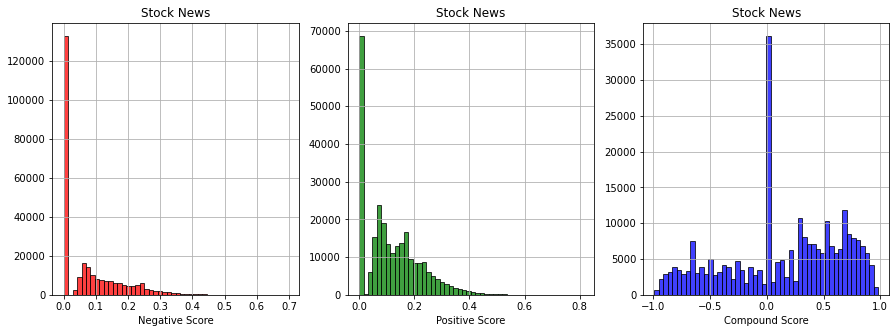

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_vader_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_vader_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(133)
plt.hist(df['stock_news_vader_compound'], 
         50, 
         color='b',
         edgecolor = 'black', 
         alpha=0.75)
plt.xlabel('Compound Score')
plt.title('Stock News')
plt.grid(True)
plt.show()

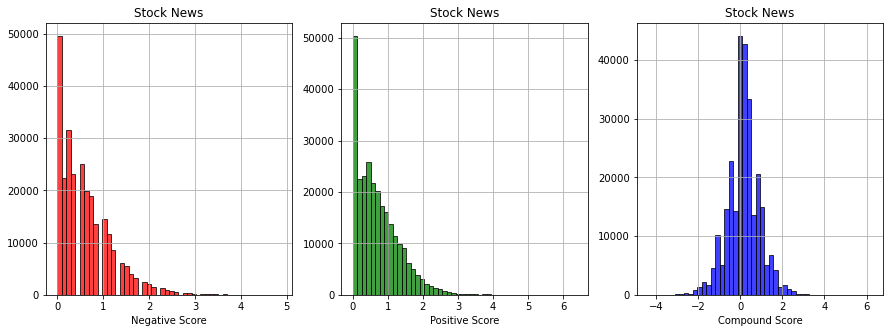

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_wordnet_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_wordnet_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(133)
plt.hist(df['stock_news_wordnet_total'], 
         50, 
         color='b',
         edgecolor = 'black', 
         alpha=0.75)
plt.xlabel('Compound Score')
plt.title('Stock News')
plt.grid(True)
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268723 entries, 0 to 540
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   symbol                     268723 non-null  object        
 1   Date                       268723 non-null  datetime64[ns]
 2   article_title              268723 non-null  object        
 3   article_abstract           268723 non-null  object        
 4   article_concat             268723 non-null  object        
 5   article_concat_pos_tag     268723 non-null  object        
 6   article_concat_lemma       268723 non-null  object        
 7   stock_news_vader_neg       268723 non-null  float64       
 8   stock_news_vader_pos       268723 non-null  float64       
 9   stock_news_vader_neu       268723 non-null  float64       
 10  stock_news_vader_compound  268723 non-null  float64       
 11  stock_news_wordnet_pos     268723 non-null  float64    

In [10]:
df.groupby(['symbol', 'Date']).size().reset_index(name='count')

,symbol,Date,count
0,A,2015-11-16,1
1,A,2016-07-28,1
2,A,2016-08-01,1
3,A,2016-08-18,1
4,A,2016-11-15,1
...,...,...,...
124340,ZTS,2021-07-22,1
124341,ZTS,2021-07-30,1
124342,ZTS,2021-08-04,1
124343,ZTS,2021-08-05,2


In [16]:
df[['symbol', 'Date', 
    'stock_news_vader_neg', 'stock_news_vader_pos', 'stock_news_vader_neu', 'stock_news_vader_compound',
    'stock_news_wordnet_pos', 'stock_news_wordnet_neg', 'stock_news_wordnet_obj', 'stock_news_wordnet_total']] \
.head()

,symbol,Date,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total
0,A,2021-07-29,0.000,0.241,0.759,0.5719,1.500,1.250,15.250,0.250
1,A,2021-07-13,0.116,0.000,0.884,-0.4404,1.500,1.625,16.875,-0.125
2,A,2021-07-12,0.000,0.087,0.913,0.2960,2.125,0.625,14.250,1.500
3,A,2021-06-25,0.058,0.096,0.846,0.2500,0.875,1.000,17.125,-0.125
4,A,2021-06-04,0.062,0.276,0.662,0.6692,1.125,0.250,13.625,0.875


In [12]:
df.groupby(['symbol', 'Date']) \
    .agg(stock_news_in_day=('Date', 'count'),
         stock_news_vader_neg=('stock_news_vader_neg', 'sum'),
         stock_news_vader_pos=('stock_news_vader_pos', 'sum'),
         stock_news_vader_neu=('stock_news_vader_neu', 'sum'),
         stock_news_vader_compound=('stock_news_vader_compound', 'sum'),
         stock_news_wordnet_pos=('stock_news_wordnet_pos', 'sum'),
         stock_news_wordnet_neg=('stock_news_wordnet_neg', 'sum'),
         stock_news_wordnet_obj=('stock_news_wordnet_obj', 'sum'),
         stock_news_wordnet_total=('stock_news_wordnet_total', 'sum'),) \
    .reset_index() \
    .to_csv('./exported_data/news_sentiment_analysis/us_stock_news_sentiment_analysis.csv', index=False)